<a href="https://colab.research.google.com/github/simony05/menu-reader/blob/main/translate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

In [35]:
translation_data = pd.read_csv('translation.csv')

In [85]:
translation_data.tail()

,Chinese,English
270,sos 大 盘 鸡 eos,sos big plate chicken eos
271,sos 火 锅 eos,sos hot pot eos
272,sos 北 京 烤 鸭 eos,sos beijing roast duck eos
273,sos 绿 茶 eos,sos green tea eos
274,sos 啤 酒 eos,sos beer eos


In [36]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
# Proprocess data
import string
import re
import unicodedata

stopwords = set(stopwords.words('english'))
def normalize(text):
  normal_text = text.lower() # All lowercase
  normal_text = normal_text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
  kept_words = [word for word in normal_text.split() if not word in stopwords] # Remove stopwords and short words
  return (" ".join(kept_words)).strip()

def unicode_to_ascii(text):
  return ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')

def add_spaces(text):
  text = unicode_to_ascii(text.lower().strip())
  text = re.sub(r'([\u4e00-\u9fff])', r" \1 ", text)
  text = re.sub(r'[" "]+', " ", text)
  return text

In [38]:
normalized_text = []

# Normalize english translations
for dish in translation_data['English']:
  normalized_text.append(normalize(dish))
translation_data['English'] = normalized_text

In [39]:
normalized_text = []

# Normalize chinese translations
for dish in translation_data['Chinese']:
  normalized_text.append(add_spaces(normalize(dish)))
translation_data['Chinese'] = normalized_text

In [40]:
translation_data

,Chinese,English
0,麻 婆 豆 腐,mapo tofu
1,家 常 豆 腐,home style sauteed tofu
2,煎 豆 腐,fried tofu
3,豆 腐 花,bean curd
4,臭 豆 腐,stinky tofu
...,...,...
270,大 盘 鸡,big plate chicken
271,火 锅,hot pot
272,北 京 烤 鸭,beijing roast duck
273,绿 茶,green tea


In [32]:
# Clean data by removing duplicates and NA
translation_data.drop_duplicates(inplace = True)
translation_data.replace('', np.nan, inplace=True)
translation_data.dropna(inplace = True)

In [41]:
# Add start and end tokens to the translations
translation_data['English'] = translation_data['English'].apply(lambda x : 'sos ' + x + ' eos')
translation_data['Chinese'] = translation_data['Chinese'].apply(lambda x : 'sos' + x + 'eos')

In [ ]:
for i in range(20):
    print("Chinese:", translation_data['Chinese'][i])
    print("English:", translation_data['English'][i])
    print("\n")

In [ ]:
import matplotlib.pyplot as plt
# Distribution of Chinese dish lengths

wordcount = []
for dish in translation_data['Chinese']:
  wordcount.append(len(dish.split()))
df = pd.Series({'Chinese dish length': wordcount})
df.hist(bins = 10)
plt.show()

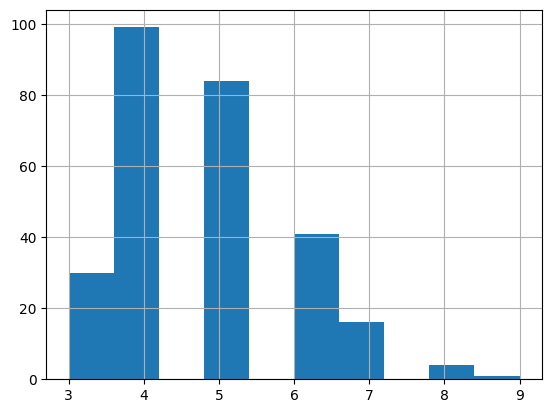

In [44]:
import matplotlib.pyplot as plt
# Distribution of English dish lengths

wordcount = []
for dish in translation_data['English']:
  wordcount.append(len(dish.split()))
df = pd.Series({'English dish length': wordcount})
df.hist(bins = 10)
plt.show()

In [45]:
CHN_MAXLEN = 9
ENG_MAXLEN = 9

In [46]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [47]:
chn_tokenizer = Tokenizer()
chn_tokenizer.fit_on_texts(list(translation_data['Chinese'])) # Dictionary of words + frequencies
chn_data = chn_tokenizer.texts_to_sequences(translation_data['Chinese'])
chn_data = pad_sequences(chn_data, maxlen = CHN_MAXLEN, padding = 'post') # Add padding at the end
chn_vocabsize  =  len(chn_tokenizer.word_index) + 1

In [48]:
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(list(translation_data['English'])) # Dictionary of words + frequencies
eng_data = eng_tokenizer.texts_to_sequences(translation_data['English'])
eng_data = pad_sequences(eng_data, maxlen = ENG_MAXLEN, padding = 'post') # Add padding at the end
eng_vocabsize  =  len(eng_tokenizer.word_index) + 1

In [49]:
# Use third party attention layer, in separate file attention.py
import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [50]:
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Concatenate
from tensorflow.keras import Input, Model

In [51]:
# Encoder
encoder_input = Input(shape = (CHN_MAXLEN,)) # Batches of MAXLEN-dimension vectors

# Embedding layer
encoder_emb_layer = Embedding(chn_vocabsize, 200)
encoder_emb = encoder_emb_layer(encoder_input)

# Encoder LSTM 1
encoder_lstm = Bidirectional(LSTM(50, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout = 0.4))
encoder_output, forward_state_h, forward_state_c, backward_state_h, backward_state_c = encoder_lstm(encoder_emb)

# Encoder outputs
encoder_h = Concatenate()([forward_state_h, backward_state_h])
encoder_c = Concatenate()([forward_state_c, backward_state_c])

# Context vector
encoder_states =[encoder_h, encoder_c]

In [52]:
# Decoder

# Decoder input
decoder_input = Input(shape = (None, ))

# Embeding layer
decoder_emb_layer = Embedding(eng_vocabsize, 200)
decoder_emb = decoder_emb_layer(decoder_input)

# Decoder LSTM 1 (input is double because encoder is birectional (forward + back = 2x))
decoder_lstm = LSTM(100, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout = 0.2)
decoder_output, _, _ = decoder_lstm(decoder_emb, initial_state = encoder_states)

# Attention layer
attention_layer = AttentionLayer()
attention_output, attention_states = attention_layer([encoder_output, decoder_output])

# Concatenate layer
decoder_concatenate = Concatenate(axis=-1)([decoder_output, attention_output])

# Dense layer
decoder_dense = Dense(eng_vocabsize, activation = 'softmax')
decoder_outputs = decoder_dense(decoder_concatenate)

# Define the model
model = Model([encoder_input, decoder_input], decoder_outputs)

In [53]:
model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

history = model.fit([chn_data, eng_data[:, :-1]],
                    eng_data[:,1:],
                    epochs = 300,
                    batch_size = 32,
                    shuffle = True,
                    validation_split=0.05,
                    )

Epoch 1/300
9/9 [==============================] - 9s 143ms/step - loss: 5.3886 - accuracy: 0.4646 - val_loss: 3.9434 - val_accuracy: 0.5714
Epoch 2/300
9/9 [==============================] - 0s 46ms/step - loss: 2.9556 - accuracy: 0.5297 - val_loss: 2.1991 - val_accuracy: 0.5714
Epoch 3/300
9/9 [==============================] - 0s 48ms/step - loss: 2.3936 - accuracy: 0.5297 - val_loss: 2.0491 - val_accuracy: 0.5714
Epoch 4/300
9/9 [==============================] - 0s 45ms/step - loss: 2.2847 - accuracy: 0.5330 - val_loss: 2.0062 - val_accuracy: 0.5714
Epoch 5/300
9/9 [==============================] - 0s 48ms/step - loss: 2.2359 - accuracy: 0.5570 - val_loss: 1.9216 - val_accuracy: 0.5804
Epoch 6/300
9/9 [==============================] - 0s 48ms/step - loss: 2.1851 - accuracy: 0.5795 - val_loss: 1.8927 - val_accuracy: 0.6339
Epoch 7/300
9/9 [==============================] - 0s 46ms/step - loss: 2.1339 - accuracy: 0.5967 - val_loss: 2.0114 - val_accuracy: 0.6339
Epoch 8/300
9/9 [==

In [54]:
model.save_weights("model.h5")

In [55]:
# Dictionaries to turn integers back to words
eng_index2word = eng_tokenizer.index_word
chn_index2word = chn_tokenizer.index_word
eng_word2index = eng_tokenizer.word_index

In [56]:
# Inference model

model.load_weights("model.h5")

# Encoder
encoder_model = Model(inputs = encoder_input, outputs = [encoder_output, encoder_h, encoder_c])

# Decoder inference
decoder_input_h = Input(shape = (100, ))
decoder_input_c = Input(shape = (100, ))

# States
decoder_hidden_input = Input(shape = (CHN_MAXLEN, 100))
decoder_input_states = [decoder_input_h, decoder_input_c]

# Embedding layer
inf_decoder_emb_layer = Embedding(eng_vocabsize, 200)
inf_decoder_emb = inf_decoder_emb_layer(decoder_input)

# Decoder LSTM
inf_decoder_lstm = LSTM(100, return_sequences = True, return_state = True)
inf_decoder_output, inf_decoder_h, inf_decoder_c = inf_decoder_lstm(inf_decoder_emb, initial_state = decoder_input_states)

# Attention layer inference
inf_attention_layer = AttentionLayer()
inf_attention_output, inf_attention_states = inf_attention_layer([decoder_hidden_input, inf_decoder_output])

# Concatenate attention output and decoder LSTM output
inf_decoder_concatenate = Concatenate(axis = -1)([inf_decoder_output, inf_attention_output])

# Dense layer
inf_decoder_dense = Dense(eng_vocabsize, activation = 'softmax')
decoder_outputs = inf_decoder_dense(inf_decoder_concatenate)

# Decoder model
decoder_model = Model(
   [decoder_input] + [decoder_hidden_input, decoder_input_h, decoder_input_c],
   [inf_decoder_output] + [inf_decoder_h, inf_decoder_c]
)

In [102]:
def decode(input):
    (encoder_output, encoder_h, encoder_c) = encoder_model.predict(input)

    target = np.zeros((1, 1))
    target[0, 0] = eng_word2index['sos']

    stop = False
    decoded_sentence = ''

    for i in range(9):
      print('hi')
      output, h, c = decoder_model.predict([target] + [encoder_output, encoder_h, encoder_c])
      print("a")
      index = np.argmax(output[0, -1, :])
      decoded_sentence += ' ' + eng_index2word[index]

      if eng_index2word[index] == 'eos':
        stop = True

      target = np.zeros((1, 1))
      target[0][0] = index

    return decoded_sentence

In [58]:
def english(input):
    decoded_sentence = ''
    for i in input:
      if((i != 0 and i != eng_word2index['sos']) and i != eng_word2index['eos']):
        decoded_sentence = decoded_sentence + eng_index2word[i]+ ' '
    return decoded_sentence

def chinese(input):
    decoded_sentence = ''
    for i in input:
      if(i != 0):
        decoded_sentence = decoded_sentence + chn_index2word[i] + ' '
    return decoded_sentence

In [103]:
for i in range(2):
  print("Chinese:", chinese(chn_data[i]))
  print("Original english:", english(eng_data[i]))
  print("Predicted english:", decode(chn_data[i].reshape(1, CHN_MAXLEN)))
  print("\n")

Chinese: sos 麻 婆 豆 腐 eos 
Original english: mapo tofu 
1/1 [==============================] - 0s 18ms/step
hi
1/1 [==============================] - 0s 23ms/step
a
hi
1/1 [==============================] - 0s 25ms/step
a
hi
1/1 [==============================] - 0s 24ms/step
a
hi
1/1 [==============================] - 0s 23ms/step
a
hi
1/1 [==============================] - 0s 21ms/step
a
hi
1/1 [==============================] - 0s 22ms/step
a
hi
1/1 [==============================] - 0s 29ms/step
a
hi
1/1 [==============================] - 0s 20ms/step
a
hi
1/1 [==============================] - 0s 20ms/step
a
Predicted english:  pig pig pig pig pig pig pig pig pig


Chinese: sos 家 常 豆 腐 eos 
Original english: home style sauteed tofu 
1/1 [==============================] - 0s 29ms/step
hi
1/1 [==============================] - 0s 24ms/step
a
hi
1/1 [==============================] - 0s 24ms/step
a
hi
1/1 [==============================] - 0s 24ms/step
a
hi
1/1 [======================